In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
from sklearn.datasets import fetch_20newsgroups

filterwarnings('ignore')

## Data Load

In [4]:
%%time
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey',
              'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'talk.politics.guns',
              'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
train_data = fetch_20newsgroups(subset='train', categories=categories)

Wall time: 266 ms


In [5]:
target_rename = {0:[0,1,2,3,4], 1:[5,6,7,8], 2:[9,10,11,12], 3:[13,14,15,16]}
target = train_data.target
for i in target_rename:
    for j in target_rename[i]:
        target = np.where(target==j, i, target) 

In [6]:
pd.Series(target).value_counts()

0    2936
1    2389
2    2373
3    1952
dtype: int64

## EDA

#### Data cleaning

In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
train_text = train_data.data.copy()

In [10]:
class preprocessing:
    def __init__(self, text):
        self.text = text
        
    def get_text(self):
        return self.text
        
    def punctuation(self):
        tokenizer = RegexpTokenizer(r'\w+')
        for i in tqdm(range(len(self.text))):
            self.text[i] = ' '.join(tokenizer.tokenize(self.text[i].lower()))
    
    def digits(self):
        tokenizer = RegexpTokenizer(r'[a-z]+')
        for i in tqdm(range(len(self.text))):
            self.text[i] = ' '.join(tokenizer.tokenize(self.text[i].lower()))
            
    def stopwords(self):
        res_stopwords = stopwords.words('english')
        for i in tqdm(range(len(self.text))):
            temp = self.text[i].split()
            new_text = ''
            for word in temp:
                if word not in res_stopwords:
                    new_text = new_text + " " + word
            self.text[i] = new_text.strip()
            
    def stemming(self):
        stemmer = PorterStemmer()
        for i in tqdm(range(len(self.text))):
            temp = self.text[i].split()
            new_text = ''
            for word in temp:
                new_text = new_text + " " + stemmer.stem(word)
            self.text[i] = new_text
            
    def drop_words_by_len(self, drop_len=2):
        for i in tqdm(range(len(self.text))):
            temp = self.text[i].split()
            new_text = ''
            for word in temp:
                if len(word) >= drop_len:
                    new_text = new_text + " " + word
            self.text[i] = new_text.strip()

In [11]:
%%time
train = preprocessing(train_text)
train.punctuation()
train.digits()
train.stopwords()
train.stemming()
train.drop_words_by_len()
train_text = train.get_text()

100%|███████████████████████████████████████████████████████████████████████████| 9650/9650 [00:00<00:00, 10610.56it/s]

Wall time: 43.2 s


In [12]:
# get all unique words
UniqueWords = set()
for i in tqdm(range(len(train_text))):
    words = train_text[i].split()
    words = set(words)
    UniqueWords = UniqueWords.union(words)
    
print('Num Unique Words: {}'.format(len(UniqueWords)))

100%|█████████████████████████████████████████████████████████████████████████████| 9650/9650 [00:17<00:00, 542.58it/s]

Num Unique Words: 65025


In [13]:
# check words distribution
num_words = dict.fromkeys(UniqueWords, 0)
for i in tqdm(range(len(train_text))):
    for word in train_text[i].split():
        num_words[word] += 1

print(len(num_words))

100%|███████████████████████████████████████████████████████████████████████████| 9650/9650 [00:00<00:00, 17082.69it/s]

65025


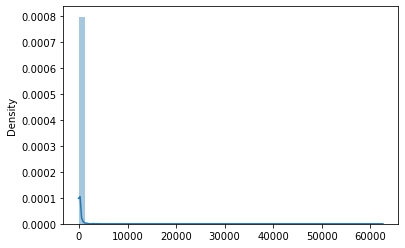

In [14]:
# plot words distribution
sns.distplot(list(num_words.values()));

In [15]:
# lets check first 50 most popular words
top_words = {k: v for k, v in sorted(num_words.items(), key=lambda item: item[1], reverse=True)}.keys()
top_words = list(top_words)[:50]
top_words = {i:num_words[i] for i in top_words}

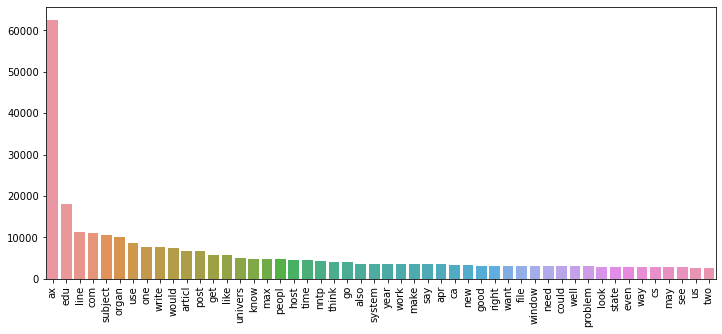

In [16]:
plt.figure(figsize=(12, 5))
sns.barplot(x=list(top_words.keys()), y=list(top_words.values()))
plt.xticks(rotation=90)
pass

In [17]:
q_down = np.quantile(list(num_words.values()), 0.01)
q_up = np.quantile(list(num_words.values()), 0.99)
drop_words = [i for i, j in num_words.items() if j >= q_up or j <= q_down]
for i in drop_words:
    num_words.pop(i)
    
len(num_words)

37319

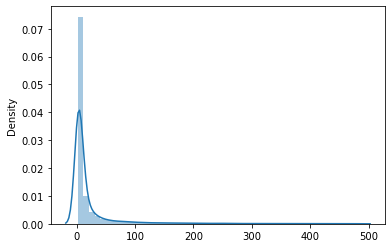

In [18]:
sns.distplot(list(num_words.values()), bins=50);

In [19]:
%%time
left_words = [i for i in num_words.keys() if i not in drop_words]

Wall time: 18.4 s


In [20]:
for i in tqdm(range(len(train_text))):
    temp = train_text[i].split()
    new_text = ''
    for word in temp:
        if word not in drop_words:
            new_text = new_text + " " + word
    train_text[i] = new_text

100%|██████████████████████████████████████████████████████████████████████████████| 9650/9650 [20:39<00:00,  7.79it/s]


In [21]:
# check text[i] == ''
for i in tqdm(train_text):
    assert i != ''

100%|█████████████████████████████████████████████████████████████████████████| 9650/9650 [00:00<00:00, 2147330.55it/s]


In [22]:
with open('corpus.txt', 'w') as f:
    for i in train_text:
        f.write(i.strip() + '\n')

## Word embeddings

In [23]:
train_text = []
with open('corpus.txt', 'r') as f:
    for i in f:
        train_text.append(i.replace('\n', ''))
        
len(train_text)

9650

#### Tfidf

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vectorizer = TfidfVectorizer()
tfidf_vect = vectorizer.fit_transform(train_text)
tfidf_vect.shape

(9650, 37319)

In [26]:
import umap

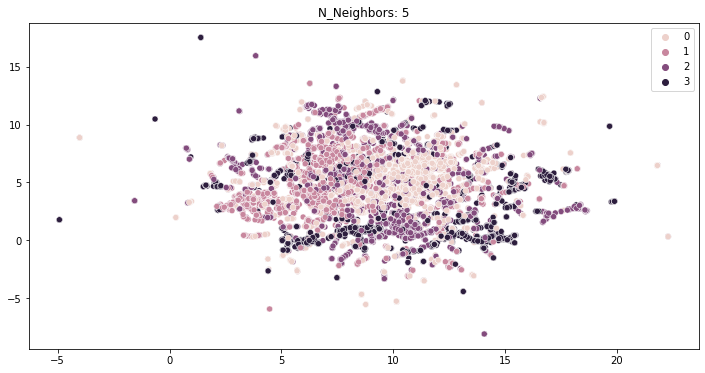

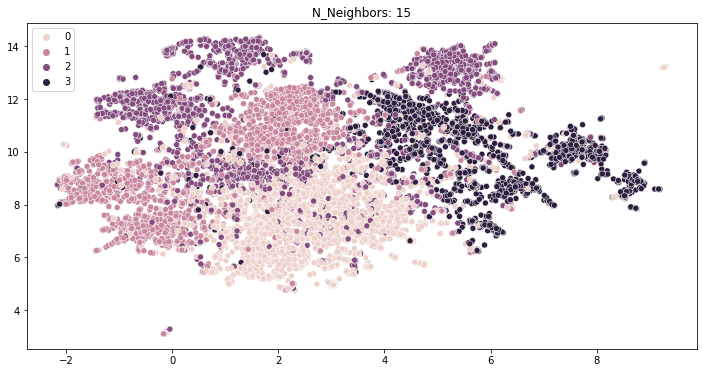

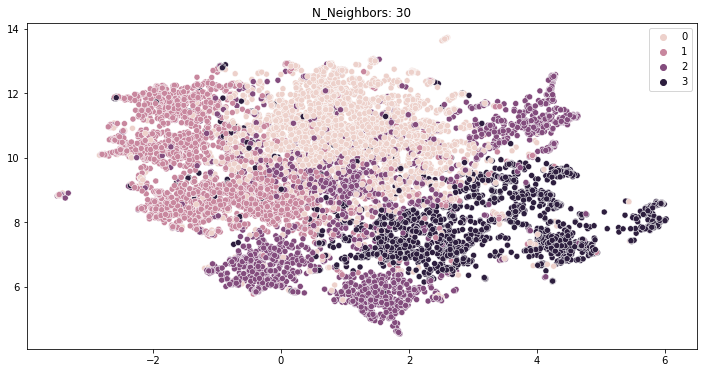

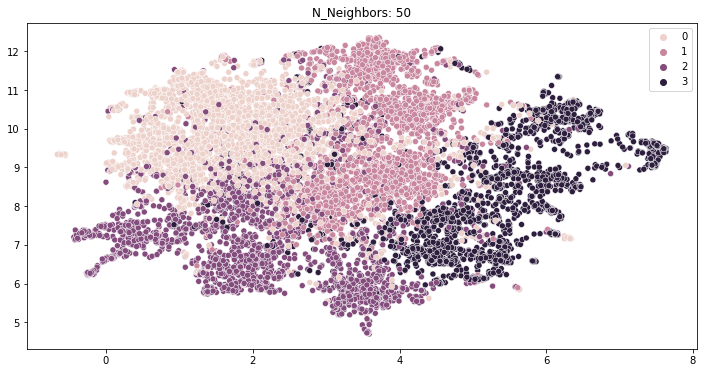

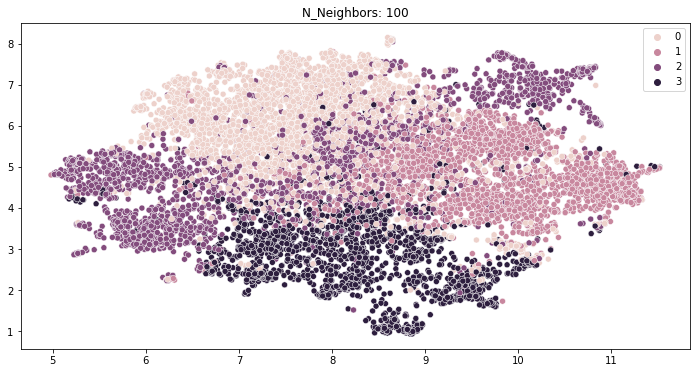

Wall time: 3min 23s


In [27]:
%%time
metric='euclidean'
for n_neighbors in [5,15,30,50,100]:
    embedding = umap.UMAP(metric=metric, n_neighbors=n_neighbors)
    new_vect = embedding.fit_transform(tfidf_vect)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=new_vect[:, 0], y=new_vect[:, 1], hue=target)
    plt.title('N_Neighbors: ' + str(n_neighbors))
    plt.show()

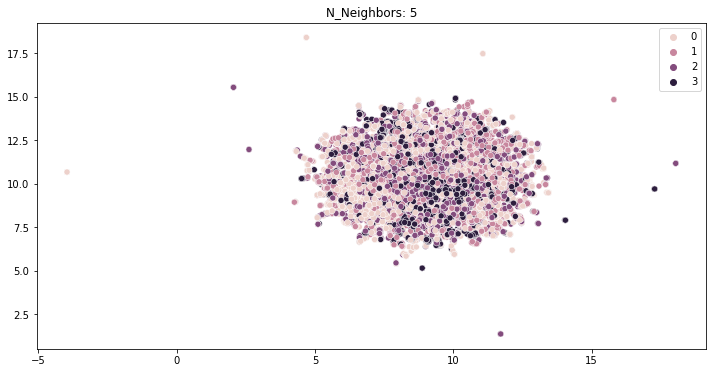

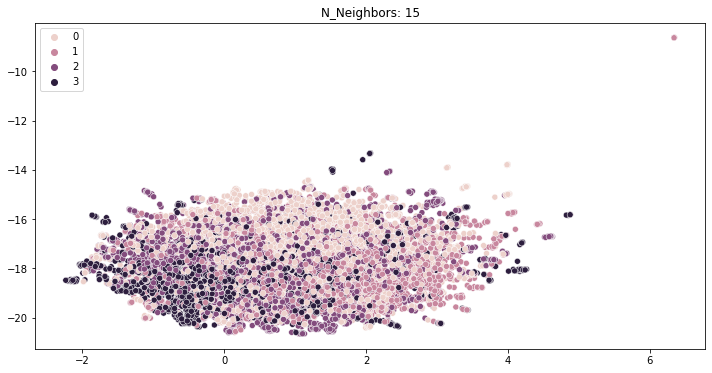

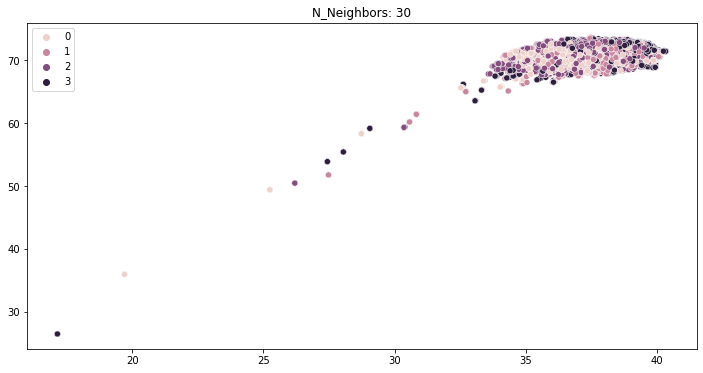

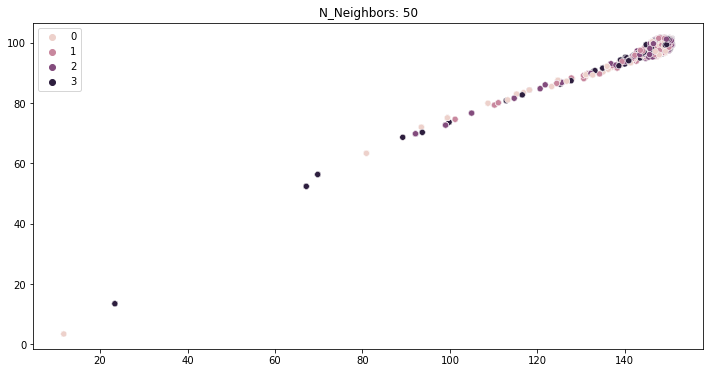

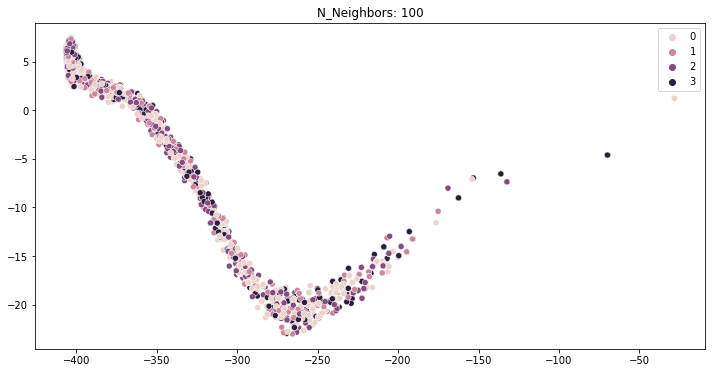

Wall time: 4min 29s


In [28]:
%%time
metric='chebyshev'
for n_neighbors in [5,15,30,50,100]:
    embedding = umap.UMAP(metric=metric, n_neighbors=n_neighbors)
    new_vect = embedding.fit_transform(tfidf_vect)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=new_vect[:, 0], y=new_vect[:, 1], hue=target)
    plt.title('N_Neighbors: ' + str(n_neighbors))
    plt.show()

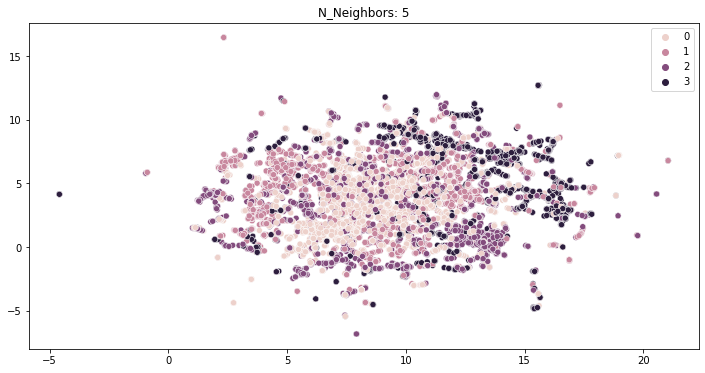

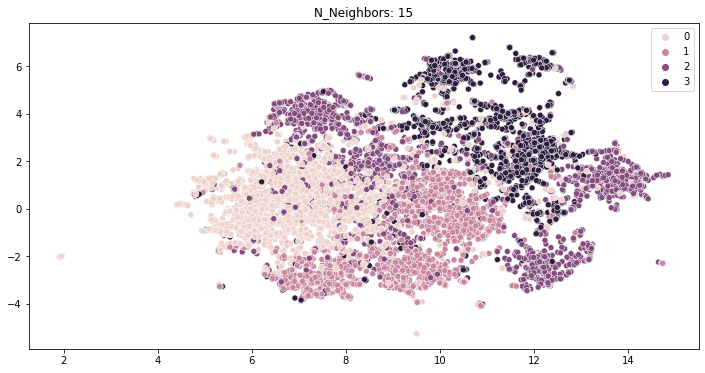

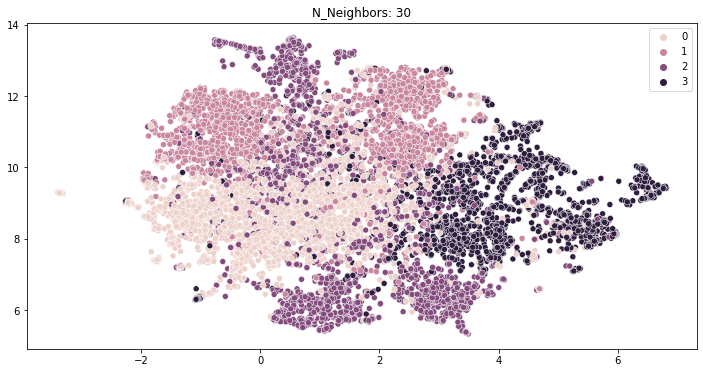

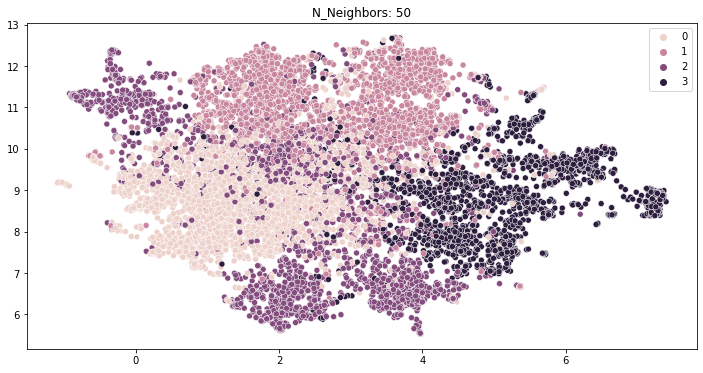

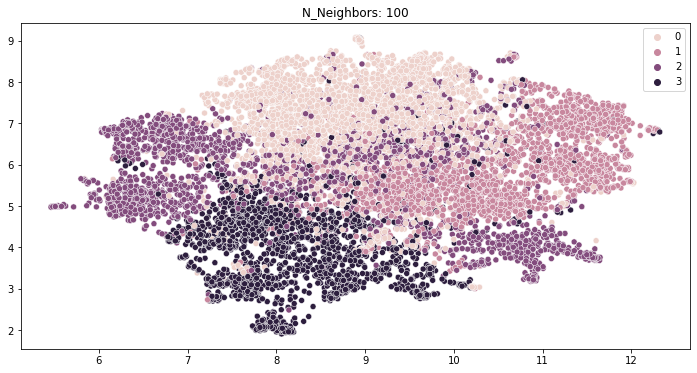

Wall time: 3min 3s


In [29]:
%%time
metric='minkowski'
for n_neighbors in [5,15,30,50,100]:
    embedding = umap.UMAP(metric=metric, n_neighbors=n_neighbors)
    new_vect = embedding.fit_transform(tfidf_vect)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=new_vect[:, 0], y=new_vect[:, 1], hue=target)
    plt.title('N_Neighbors: ' + str(n_neighbors))
    plt.show()

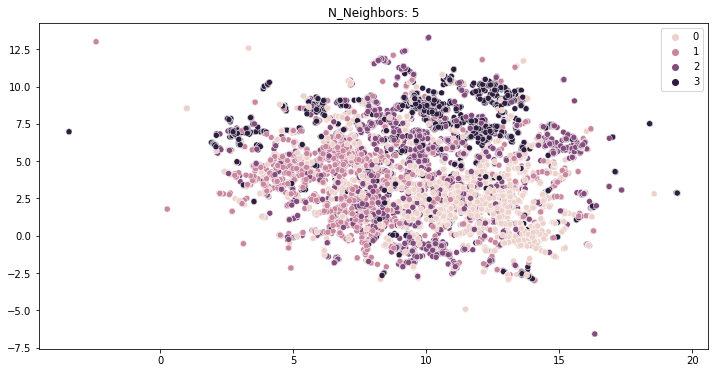

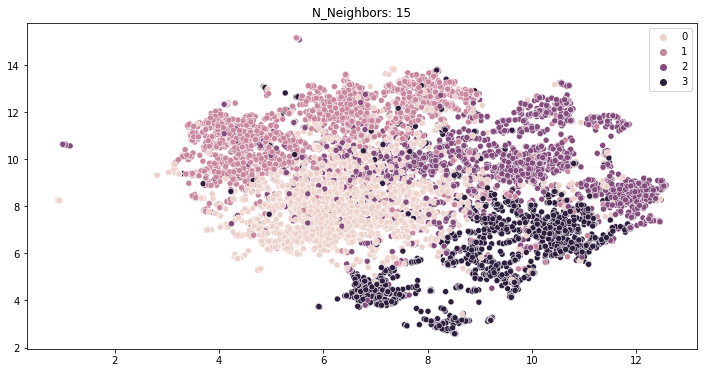

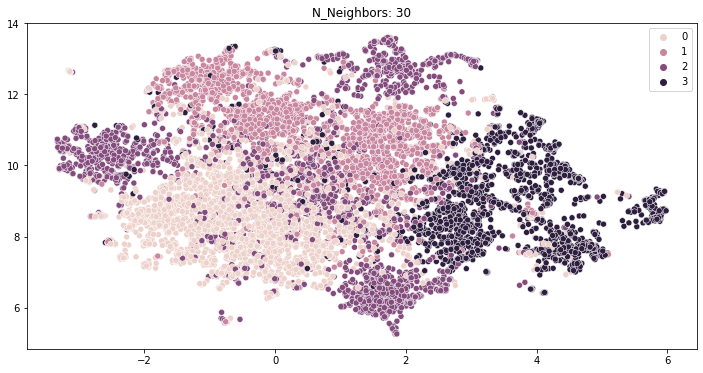

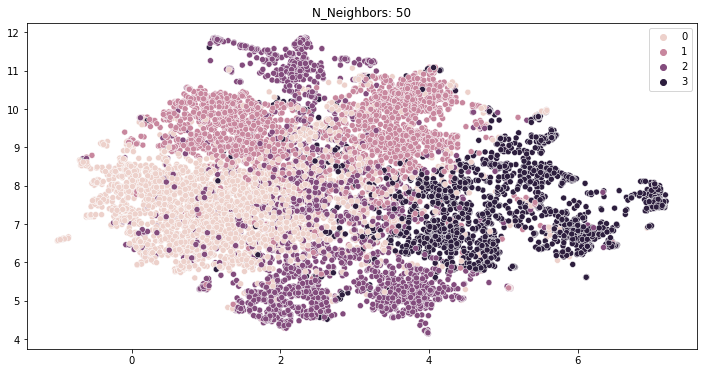

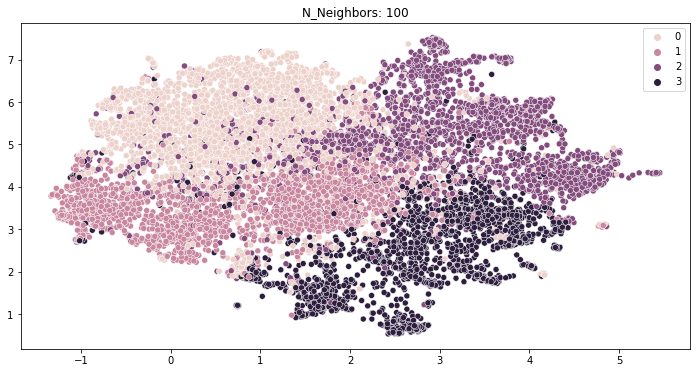

Wall time: 2min 58s


In [30]:
%%time
metric='cosine'
for n_neighbors in [5,15,30,50,100]:
    embedding = umap.UMAP(metric=metric, n_neighbors=n_neighbors)
    new_vect = embedding.fit_transform(tfidf_vect)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=new_vect[:, 0], y=new_vect[:, 1], hue=target)
    plt.title('N_Neighbors: ' + str(n_neighbors))
    plt.show()

## Clusterization

Попробуем некоторые алгоритмы класстеризации и посмотрим на их качество

In [14]:
np.random.seed = 42
split = np.array([i for i in range(9650)])
np.random.shuffle(split)
train_indexes, test_indexes = split[:9000], split[9000:]

In [15]:
tfidf_train, tfidf_test = tfidf_vect[train_indexes], tfidf_vect[test_indexes]
labels_train, labels_test = target[train_indexes], target[test_indexes]

In [16]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics.cluster import silhouette_score, adjusted_rand_score, fowlkes_mallows_score

##### KMeans

In [156]:
%%time
model = KMeans(n_clusters=4, random_state=42)
model.fit(tfidf_train)
tfidf_pred = model.predict(tfidf_test)

print('Silhouette', silhouette_score(tfidf_test.toarray(), tfidf_pred))
print('Rand Score', adjusted_rand_score(labels_test, tfidf_pred))
print('Fowlkes', fowlkes_mallows_score(labels_test, tfidf_pred))

Silhouette 0.0009790728509440356
Rand Score 0.1439589848449993
Fowlkes 0.4743532736192418
Wall time: 23.6 s


##### Agglomerative Clustering

In [125]:
%%time
model = AgglomerativeClustering(n_clusters=4)
tfidf_pred = model.fit_predict(tfidf_vect.toarray())

print('Silhouette', silhouette_score(tfidf_vect.toarray(), tfidf_pred))
print('Rand Score', adjusted_rand_score(target, tfidf_pred))
print('Fowlkes', fowlkes_mallows_score(target, tfidf_pred))

Silhouette 0.0008241790579854179
Rand Score 0.006250351505956816
Fowlkes 0.4977796416520372
Wall time: 34min 36s


##### DBSCAN

In [150]:
%%time
model = DBSCAN()
model.fit_predict(tfidf_vect)

print('Silhouette', silhouette_score(tfidf_vect, model.labels_))

Silhouette -0.003939926760660975
Wall time: 3.66 s


##### Clussification

In [129]:
%%time
# try clussification
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(tfidf_train, labels_train)
tfidf_pred = model.predict(tfidf_test)

model.score(tfidf_test, labels_test)

Wall time: 385 ms


0.9061538461538462

### HyperOpt

In [131]:
# hyperopt KMeans
from sklearn.model_selection import KFold
split = KFold(5)
scores_list = []

for n_init in tqdm([5, 10, 20, 40, 50, 70]):
    for init in ['k-means++', 'random']:
        score = []
        for train_index, test_index in split.split(tfidf_vect):
            X_train, X_test = tfidf_vect[train_index], tfidf_vect[test_index]
            y_train, y_test = target[train_index], target[test_index]
            model = KMeans(n_clusters=4, random_state=42, n_init=n_init,init=init)
            model.fit(X_train)
            temp_pred = model.predict(X_test)
            temp_score = fowlkes_mallows_score(y_test, temp_pred)
            score.append(temp_score)
        score = sum(score) / 5
        scores_list.append([{'n_init':n_init, 'init':init}, score])

100%|██████████| 6/6 [1:17:54<00:00, 779.06s/it]


In [132]:
sorted(scores_list, key = lambda x: x[1], reverse=True)[:5]

[[{'n_init': 20, 'init': 'k-means++'}, 0.4941406732631412],
 [{'n_init': 20, 'init': 'random'}, 0.4926455353376621],
 [{'n_init': 70, 'init': 'random'}, 0.4923208153603843],
 [{'n_init': 50, 'init': 'k-means++'}, 0.4905746009195414],
 [{'n_init': 70, 'init': 'k-means++'}, 0.4905746009195414]]

In [169]:
# hyperopt KMeans
from sklearn.model_selection import KFold
split = KFold(5)
scores_list = []

for n_init in tqdm([5, 10, 20, 40, 50, 70]):
    for init in ['k-means++', 'random']:
        score = []
        for train_index, test_index in split.split(tfidf_vect):
            X_train, X_test = tfidf_vect[train_index], tfidf_vect[test_index]
            y_train, y_test = target[train_index], target[test_index]
            model = KMeans(n_clusters=4, random_state=42, n_init=n_init,init=init)
            model.fit(X_train)
            temp_pred = model.predict(X_test)
            temp_score = adjusted_rand_score(y_test, temp_pred)
            score.append(temp_score)
        score = sum(score) / 5
        scores_list.append([{'n_init':n_init, 'init':init}, score])

100%|██████████| 6/6 [1:21:48<00:00, 818.01s/it] 


In [170]:
sorted(scores_list, key = lambda x: x[1], reverse=True)[:5]

[[{'n_init': 50, 'init': 'k-means++'}, 0.17939154399043025],
 [{'n_init': 70, 'init': 'k-means++'}, 0.17939154399043025],
 [{'n_init': 10, 'init': 'k-means++'}, 0.17333957408521028],
 [{'n_init': 20, 'init': 'k-means++'}, 0.17047159040451398],
 [{'n_init': 40, 'init': 'k-means++'}, 0.16489491781706]]

In [17]:
%%time
model = KMeans(n_clusters=4, random_state=42, n_init=50, init='k-means++')
model.fit(tfidf_vect)
tfidf_pred = model.predict(tfidf_vect)

print('Silhouette', silhouette_score(tfidf_vect, tfidf_pred))
print('Rand Score', adjusted_rand_score(target, tfidf_pred))
print('Fowlkes', fowlkes_mallows_score(target, tfidf_pred))

Silhouette 0.0019117527656050412
Rand Score 0.204446743876008
Fowlkes 0.5060877957220423
Wall time: 2min 6s


In [20]:
%%time
embedding = umap.UMAP(metric='cosine', n_neighbors=50)
new_vect = embedding.fit_transform(tfidf_vect)
df_viz = pd.DataFrame({'y':target, 'y_hat':tfidf_pred, 'x_plot':new_vect[:, 0], 'y_plot':new_vect[:, 1]})

Wall time: 51.4 s


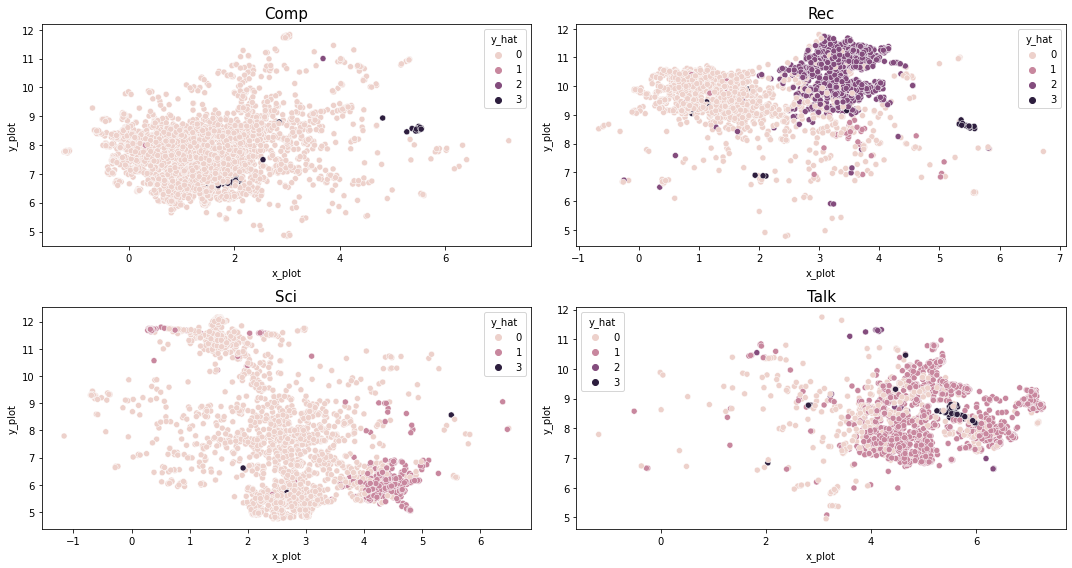

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
df_viz_0 = df_viz.loc[df_viz['y']==0]
df_viz_1 = df_viz.loc[df_viz['y']==1]
df_viz_2 = df_viz.loc[df_viz['y']==2]
df_viz_3 = df_viz.loc[df_viz['y']==3]

sns.scatterplot(x=df_viz_0['x_plot'], y=df_viz_0['y_plot'], hue=df_viz_0['y_hat'], ax=ax[0][0])
sns.scatterplot(x=df_viz_1['x_plot'], y=df_viz_1['y_plot'], hue=df_viz_1['y_hat'], ax=ax[0][1])
sns.scatterplot(x=df_viz_2['x_plot'], y=df_viz_2['y_plot'], hue=df_viz_2['y_hat'], ax=ax[1][0])
sns.scatterplot(x=df_viz_3['x_plot'], y=df_viz_3['y_plot'], hue=df_viz_3['y_hat'], ax=ax[1][1])

ax[0][0].set_title('Comp', fontsize=15)
ax[0][1].set_title('Rec', fontsize=15)
ax[1][0].set_title('Sci', fontsize=15)
ax[1][1].set_title('Talk', fontsize=15)

plt.tight_layout()
pass

In [236]:
%%time
model = KMeans(n_clusters=4, random_state=42, n_init=50, init='k-means++')
model.fit(tfidf_train)
tfidf_pred = model.predict(tfidf_test)

print('Silhouette', silhouette_score(tfidf_test, tfidf_pred))
print('Rand Score', adjusted_rand_score(labels_test, tfidf_pred))
print('Fowlkes', fowlkes_mallows_score(labels_test, tfidf_pred))

Silhouette 0.0014976866566534395
Rand Score 0.16097410547923433
Fowlkes 0.4907888894676385
Wall time: 2min 23s


In [237]:
embedding = umap.UMAP(metric='cosine', n_neighbors=50)
new_vect = embedding.fit_transform(tfidf_test)
df_viz = pd.DataFrame({'y':labels_test, 'y_hat':tfidf_pred, 'x_plot':new_vect[:, 0], 'y_plot':new_vect[:, 1]})

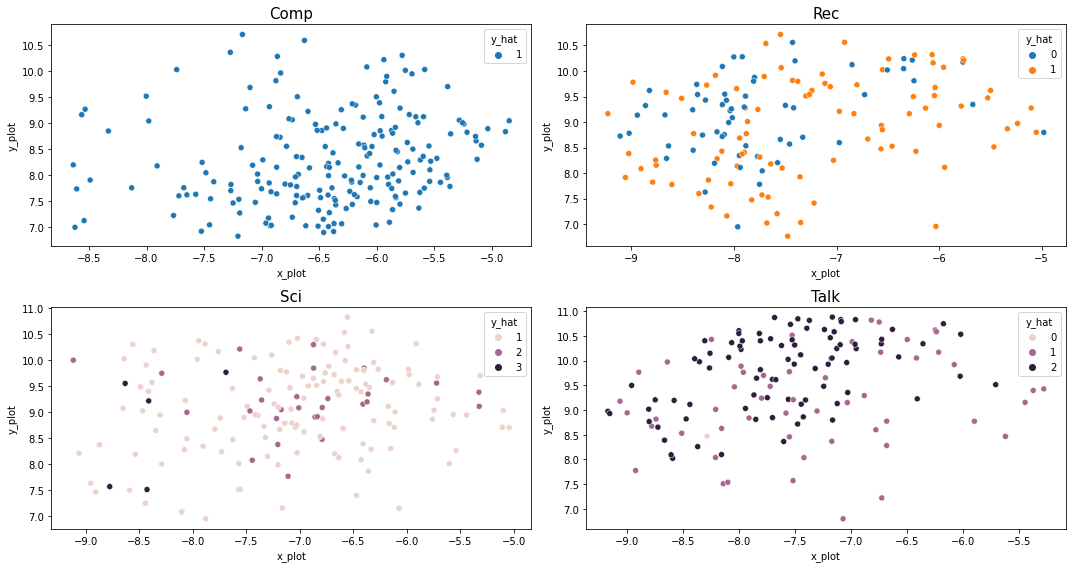

In [238]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
df_viz_0 = df_viz.loc[df_viz['y']==0]
df_viz_1 = df_viz.loc[df_viz['y']==1]
df_viz_2 = df_viz.loc[df_viz['y']==2]
df_viz_3 = df_viz.loc[df_viz['y']==3]

sns.scatterplot(x=df_viz_0['x_plot'], y=df_viz_0['y_plot'], hue=df_viz_0['y_hat'], ax=ax[0][0])
sns.scatterplot(x=df_viz_1['x_plot'], y=df_viz_1['y_plot'], hue=df_viz_1['y_hat'], ax=ax[0][1])
sns.scatterplot(x=df_viz_2['x_plot'], y=df_viz_2['y_plot'], hue=df_viz_2['y_hat'], ax=ax[1][0])
sns.scatterplot(x=df_viz_3['x_plot'], y=df_viz_3['y_plot'], hue=df_viz_3['y_hat'], ax=ax[1][1])

ax[0][0].set_title('Comp', fontsize=15)
ax[0][1].set_title('Rec', fontsize=15)
ax[1][0].set_title('Sci', fontsize=15)
ax[1][1].set_title('Talk', fontsize=15)

plt.tight_layout()
pass

##### Check how clussification work

In [239]:
%%time
# try clussification
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(tfidf_vect, target)
tfidf_pred = model.predict(tfidf_vect)

model.score(tfidf_vect, target)

Wall time: 5.4 s


0.9350259067357513

In [241]:
embedding = umap.UMAP(metric='cosine', n_neighbors=50)
new_vect = embedding.fit_transform(tfidf_vect)
df_viz = pd.DataFrame({'y':target, 'y_hat':tfidf_pred, 'x_plot':new_vect[:, 0], 'y_plot':new_vect[:, 1]})

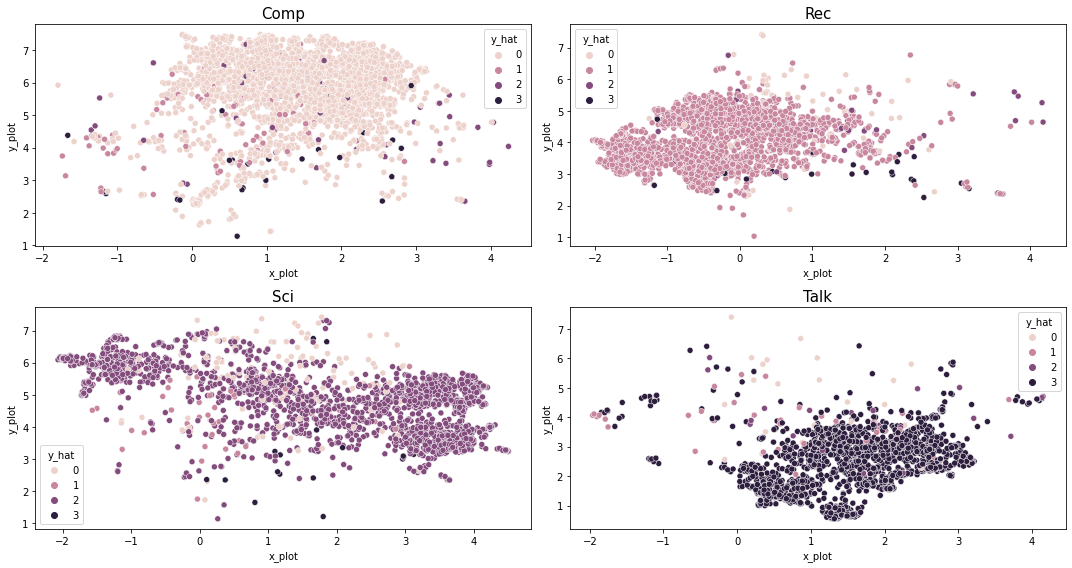

In [242]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
df_viz_0 = df_viz.loc[df_viz['y']==0]
df_viz_1 = df_viz.loc[df_viz['y']==1]
df_viz_2 = df_viz.loc[df_viz['y']==2]
df_viz_3 = df_viz.loc[df_viz['y']==3]

sns.scatterplot(x=df_viz_0['x_plot'], y=df_viz_0['y_plot'], hue=df_viz_0['y_hat'], ax=ax[0][0])
sns.scatterplot(x=df_viz_1['x_plot'], y=df_viz_1['y_plot'], hue=df_viz_1['y_hat'], ax=ax[0][1])
sns.scatterplot(x=df_viz_2['x_plot'], y=df_viz_2['y_plot'], hue=df_viz_2['y_hat'], ax=ax[1][0])
sns.scatterplot(x=df_viz_3['x_plot'], y=df_viz_3['y_plot'], hue=df_viz_3['y_hat'], ax=ax[1][1])

ax[0][0].set_title('Comp', fontsize=15)
ax[0][1].set_title('Rec', fontsize=15)
ax[1][0].set_title('Sci', fontsize=15)
ax[1][1].set_title('Talk', fontsize=15)

plt.tight_layout()
pass